In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# rcParams.update({
#     "font.size": 16})
# rcParams['axes.titlepad'] = 20

## Load in Data

In [2]:
from boutdata import collect
from boutdata.data import BoutData
import re
import os

job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()
job_id = job_ids[-1]
# job_id = '5688618'
print('job_id', job_id)
path = './shared/NORTH/data_' + job_id + '/'

job_id 5699565


In [3]:
bdata = BoutData(path)
outputs = bdata['outputs']
field_keys = outputs.keys()
options = bdata['options']

/home/niflheim/s173965/local/venv/north-simulation/lib64/python3.6/site-packages/boutdata/data.py:769: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  + "\nEvaluating non-scalar options not available"


In [4]:
def get_option(*keys):
    from numpy import sqrt, pi
    from ast import parse, walk, Name
    val = options
    group = keys[0]
    for key in keys:
        val = val[key]
    try:
        return eval(str(val))
    except:
        # Parse undefined variables from the Bout.inp file:
        val_str = str(val).replace(':', '____') # Replace group indicator ':' with '____' to make string parsable.
        for node in walk(parse(val_str)):
            if type(node) is Name:
                missing_keys = node.id.split('____')
                var = missing_keys[-1]
                if var not in locals():
                    try:
                        locals()[var] = get_option(*missing_keys)
                    except:
                        missing_keys.insert(0, group)
                        try:
                            locals()[var] = get_option(*missing_keys)
                        except:
                            print('Error reading option for keys: ', keys)
                            return 0
        return eval(str(val))

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [5]:
oci, rho_s, R, n0, n_n, E_ion, mxg, myg, nx_all, ny_all, nz_all = get_options([
    ('north', 'oci'), ('north', 'rho_s'), ('north', 'R'), ('north', 'n0'), ('north', 'n_n'), ('north', 'E_ion'),
    ('mxg',), ('myg',),
    ('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
Lx = R/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

In [6]:
print('nx: ', options['mesh']['nx'])
print('ny: ', options['mesh']['ny'])
print('nz: ', options['mesh']['nz'])
print('Lx: ', options['mesh']['Lx'])
print('rho_s: ', options['north']['rho_s'])
print('oci: ', options['north']['oci'])

nx:  48+2*mxg
ny:  1
nz:  128
Lx:  north:a/north:rho_s
rho_s:  c_s/oci
oci:  e*B0/(mi)


In [7]:
#%% Read data

field_list  = ['B', 'T', 'n', 'phi', 'vort', 'source_T', 'wall_shadow']
par_list    = ['t_array']
# fast_list   = ['t_array', 'n0', 'phi0', 'n1', 'phi1', 'n2', 'phi2', 'T0', 'T1', 'T2']
#%%
data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

mxsub = 2 mysub = 1 mz = 128

nxpe = 24, nype = 1, npes = 24

Reading from 0: [2-3][0-0] -> [0-1][0-0]

Reading from 1: [2-3][0-0] -> [2-3][0-0]

Reading from 2: [2-3][0-0] -> [4-5][0-0]

Reading from 3: [2-3][0-0] -> [6-7][0-0]

Reading from 4: [2-3][0-0] -> [8-9][0-0]

Reading from 5: [2-3][0-0] -> [10-11][0-0]

Reading from 6: [2-3][0-0] -> [12-13][0-0]

Reading from 7: [2-3][0-0] -> [14-15][0-0]

Reading from 8: [2-3][0-0] -> [16-17][0-0]

Reading from 9: [2-3][0-0] -> [18-19][0-0]

Reading from 10: [2-3][0-0] -> [20-21][0-0]

Reading from 11: [2-3][0-0] -> [22-23][0-0]

Reading from 12: [2-3][0-0] -> [24-25][0-0]

Reading from 13: [2-3][0-0] -> [26-27][0-0]

Reading from 14: [2-3][0-0] -> [28-29][0-0]

Reading from 15: [2-3][0-0] -> [30-31][0-0]

Reading from 16: [2-3][0-0] -> [32-33][0-0]

Reading from 17: [2-3][0-0] -> [34-35][0-0]

Reading from 18: [2-3][0-0] -> [36-37][0-0]

Reading from 19: [2-3][0-0] -> [38-39][0-0]

Reading from 20: [2-3][0-0] -> [40-41][0-0]

Reading from 

In [8]:
data['p'] = data['n'] * data['T']

def k_ionization(T):
    return 2.0e-13*np.sqrt(T/E_ion)/(6.0 + T/E_ion)*np.exp(-E_ion/T)*n0/(oci)
data['S_n'] = n_n*data['n']*k_ionization(data['T'])


In [9]:
thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(Lx/(2*nx_inner), Lx+Lx/(2*nx_inner), nx_inner)

## Plot Time Frames

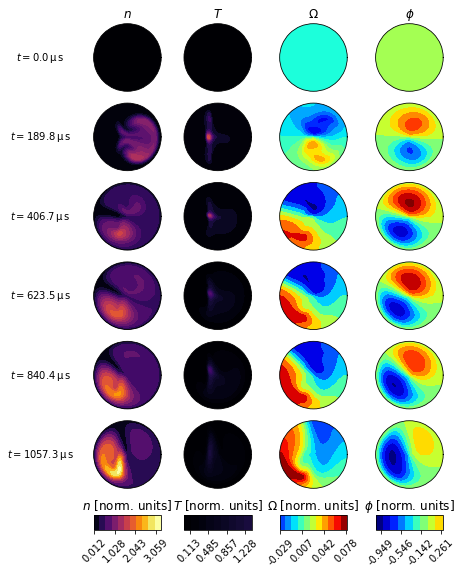

In [11]:
from matplotlib.gridspec import GridSpec

def cbar_ticks(vmin, vmax, n_ticks=4, label_rounding=2):
    ticks = np.linspace(vmin, vmax, n_ticks, endpoint=True)
    labels = np.round(ticks,3)
    return ticks, labels

def plot_time_frames(start_frame=0, end_frame=None):
    fields = ['n', 'T', 'vort', 'phi']
    cmaps = ['inferno', 'inferno', 'jet', 'jet']
    titles = [r'$n$', r'$T$', r'$\Omega$', r'$\phi$']
    N_frames = 6
    cm = 1/2.54 # 1 cm = 1/2.54 inch
    nrows = 5*N_frames + 1 # 5 (merged rows) for each frame plot. 1 row for colobar
    n_cols = 1 + len(fields)*6 # 1 column for each timestamp text. 3 (merged columns) for each field plot.
    fig = plt.figure(constrained_layout=True, figsize=(16*cm, 20*cm))
    gs = GridSpec(nrows, n_cols, figure=fig)
    def get_row_range(i_frame):
        return slice(5*i_frame,5*(i_frame+1))
    def get_col_range(i_field):
        return slice(1+6*i_field,1+6*(i_field+1))
    if end_frame is None:
        end_frame = data[fields[0]].shape[0]
    frames = np.linspace(start_frame, end_frame - 1, N_frames, dtype=int)
    # frames = np.arange(start_frame, end_frame, int(np.ceil(end_frame/N_frames)))

    for i_frame, frame in enumerate(frames):
        row_range = get_row_range(i_frame)
        ax = fig.add_subplot(gs[row_range, 0])
        ax.text(0.5, 0.5, r'$t = ' + str(round(times[frame]*(10**6),1)) + '\, \mathrm{\mu \, s}$', va="center", ha="center")
        plt.axis('off')

    for i_field, field in enumerate(fields):
        field_data = data[field].squeeze()
        vmin = field_data.min()
        vmax = field_data.max()
        col_range = get_col_range(i_field)
        for i_frame, frame in enumerate(frames):
            row_range = get_row_range(i_frame)
            ax = fig.add_subplot(gs[row_range, col_range], polar=True)
            if i_frame == 0:
                ax.set_title(titles[i_field])
            cont = ax.contourf(thetas, rhos, field_data[frame, :, :], 10, cmap = cmaps[i_field], vmin=vmin, vmax=vmax)
            ax.set_rticks([])
            ax.set_xticks([])

        cax = fig.add_subplot(gs[-1, col_range])
        latest = field_data[frames[-1], :, :]
        c_ticks, c_labels = cbar_ticks(latest.min(), latest.max())
        cbar = fig.colorbar(cont, cax=cax, ticks=c_ticks, orientation='horizontal')
        cax.set_title(titles[i_field] + ' [norm. units]')
        cbar.ax.set_xticklabels(c_labels, rotation=45)
    return fig

fig = plot_time_frames()

## gif Animations

In [13]:
import matplotlib.animation as animation

def get_cmap(cmap, min_p=0.0, N_cmap=256):
    cmap = plt.get_cmap(cmap)
    return ListedColormap(cmap(np.linspace(0,1,int(N_cmap/(1-min_p))))[-N_cmap:,:])

def get_cbar_mappable(cmap, vmin, vmax):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    return mpl.cm.ScalarMappable(norm=norm, cmap=get_cmap(cmap))

def get_extend(field_data, vmin, vmax):
    if field_data.min() < vmin and vmax >= field_data.max():
        return 'min'
    elif field_data.min() <= vmin and vmax < field_data.max():
        return 'max'
    elif field_data.min() < vmin and vmax < field_data.max():
        return 'both'
    else:
        return 'neither'

def plot_first_frame(field, cmap='inferno', vmin = None, vmax = None, frame=0):
    field_data = data[field].squeeze()
    if vmin is None:
        vmin = field_data.min()
    if vmax is None:
        vmax = field_data.max()
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_rticks([])
    ax.set_xticks([])
    ax.contourf(thetas, rhos, field_data[frame, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)    # first image on screen
    fig.colorbar(get_cbar_mappable(cmap, vmin, vmax), orientation='vertical', label=r'$' + field + '$ [norm. u.]', extend=get_extend(field_data, vmin, vmax), ax=ax)
    fig.tight_layout()
    return fig, ax, field_data, vmin, vmax

def animate_data(field, cmap='inferno', vmin = None, vmax = None):
    fig, ax, field_data, vmin, vmax = plot_first_frame(field, cmap, vmin, vmax)

    # animation function
    def animate(i):
        for c in ax.collections:
            c.remove()  # removes only the contours, leaves the rest intact
        cont = ax.contourf(thetas, rhos, field_data[i, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)
        return cont.collections
    
    anim = animation.FuncAnimation(fig, animate, frames=field_data.shape[0], interval=100, blit=True)
    anim.save('./plots/' + job_id + '_animation_' + field +'.gif', fps=4)
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


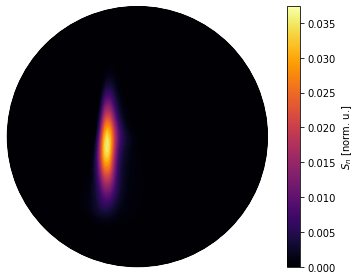

In [14]:
animate_data('S_n', vmax=np.quantile(data['S_n'], 1.0))

MovieWriter ffmpeg unavailable; using Pillow instead.


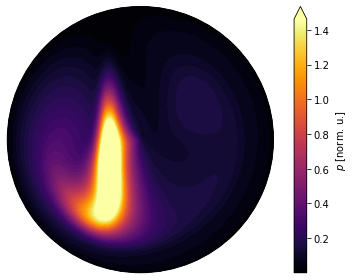

In [15]:
animate_data('p', vmax=np.quantile(data['p'], 0.99))

MovieWriter ffmpeg unavailable; using Pillow instead.


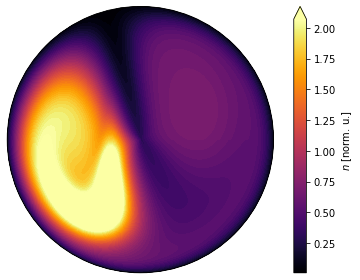

In [16]:
animate_data('n', vmax=np.quantile(data['n'], 0.99))

MovieWriter ffmpeg unavailable; using Pillow instead.


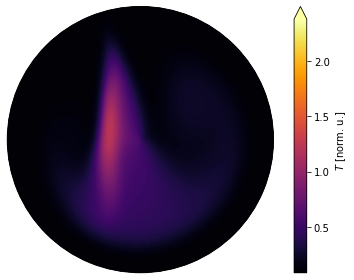

In [17]:
animate_data('T', vmax=np.quantile(data['T'], 0.99))

MovieWriter ffmpeg unavailable; using Pillow instead.


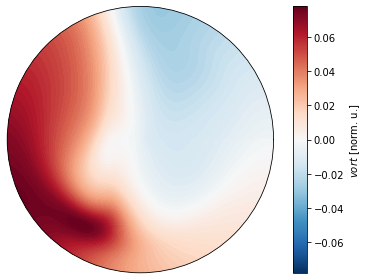

In [24]:
# SET VMIN AND VMAX to symmetrise around 0
vmax = np.max([data['vort'].max(), np.abs(data['vort'].min())])
vmin = -vmax

animate_data('vort', cmap='RdBu_r', vmin=vmin, vmax=vmax)

MovieWriter ffmpeg unavailable; using Pillow instead.


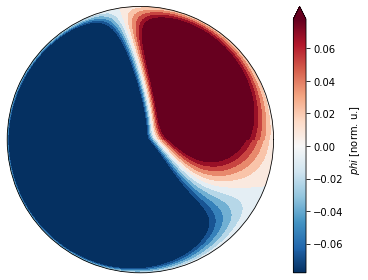

In [25]:
vmax = np.max([data['phi'].max(), np.abs(data['phi'].min())])
vmin = -vmax

animate_data('phi', cmap='RdBu_r', vmin=vmin, vmax=vmax)